In [4]:
import numpy as np
import pandas as pd
import anndata as ad
from scipy.sparse import csr_matrix
import scanpy as sc
from itertools import chain


import itertools
import networkx as nx


import scglue
import seaborn as sns
from matplotlib import rcParams
print(ad.__version__)

0.10.7


In [5]:
rna = ad.read_h5ad("rna0703_lbc_st.h5ad")
meta_full = ad.read_h5ad("meta0719_clz92_01.h5ad")
guidance = nx.read_graphml("Guidance_0706_lbc_clz92_01.graphml.gz")

In [6]:
# Set the random seed for reproducibility
np.random.seed(42)

# Randomly select 1601 indices from the total number of observations
random_indices = np.random.choice(meta_full.shape[0], 2172, replace=False)

# Subset the AnnData object based on the randomly selected indices
meta = meta_full[random_indices, :]

# Print information about the subsetted AnnData object
meta

View of AnnData object with n_obs × n_vars = 2172 × 947
    obs: 'leiden', 'cluster'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'cluster_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_spatial', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [7]:
rna

AnnData object with n_obs × n_vars = 2172 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'leiden', 'cluster'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'cluster_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [8]:

meta

View of AnnData object with n_obs × n_vars = 2172 × 947
    obs: 'leiden', 'cluster'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'cluster_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_spatial', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [9]:
scglue.graph.check_graph(guidance, [rna, meta])

[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] check_graph: All checks passed!


In [10]:
scglue.models.configure_dataset(
    rna, "ZINB", use_layer="counts",use_highly_variable=True,
    use_rep="X_pca"
)

In [11]:
scglue.models.configure_dataset(
    meta, "ZINB", use_layer="counts",use_highly_variable=True,
     use_rep="X_pca"
)

/home/by/anaconda3/lib/python3.10/site-packages/scglue/models/__init__.py:124: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[config.ANNDATA_KEY] = data_config


In [12]:
guidance_hvf = guidance.subgraph(chain(
    rna.var.query("highly_variable").index,
    meta.var.query("highly_variable").index
)).copy()

In [12]:
glue = scglue.models.fit_SCGLUE(
    {"rna": rna, "meta": meta}, guidance_hvf,
    fit_kws={"directory": "glue"}
)

[INFO] fit_SCGLUE: Pretraining SCGLUE model...
[INFO] autodevice: Using CPU as computation device.
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 1377
[INFO] SCGLUEModel: Setting `max_epochs` = 786
[INFO] SCGLUEModel: Setting `patience` = 66
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 33


/home/by/anaconda3/lib/python3.10/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)


[INFO] SCGLUETrainer: Using training directory: "glue/pretrain"


/home/by/anaconda3/lib/python3.10/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)


[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.166, 'g_kl': 0.018, 'g_elbo': 0.184, 'x_rna_nll': 0.33, 'x_rna_kl': 0.009, 'x_rna_elbo': 0.339, 'x_meta_nll': 0.898, 'x_meta_kl': 0.046, 'x_meta_elbo': 0.945, 'dsc_loss': 0.687, 'vae_loss': 1.291, 'gen_loss': 1.257}, val={'g_nll': 0.15, 'g_kl': 0.019, 'g_elbo': 0.17, 'x_rna_nll': 0.308, 'x_rna_kl': 0.008, 'x_rna_elbo': 0.316, 'x_meta_nll': 0.902, 'x_meta_kl': 0.04, 'x_meta_elbo': 0.942, 'dsc_loss': 0.693, 'vae_loss': 1.265, 'gen_loss': 1.23}, 4.4s elapsed
[INFO] SCGLUETrainer: [Epoch 20] train={'g_nll': 0.057, 'g_kl': 0.036, 'g_elbo': 0.094, 'x_rna_nll': 0.314, 'x_rna_kl': 0.005, 'x_rna_elbo': 0.319, 'x_meta_nll': 0.806, 'x_meta_kl': 0.028, 'x_meta_elbo': 0.834, 'dsc_loss': 0.684, 'vae_loss': 1.156, 'gen_loss': 1.122}, val={'g_nll': 0.053, 'g_kl': 0.037, 'g_elbo': 0.09, 'x_rna_nll': 0.281, 'x_rna_kl': 0.004, 'x_rna_elbo': 0.285, 'x_meta_nll': 0.808, 'x_meta_kl': 0.021, 'x_meta_elbo': 0.829, 'dsc_loss': 0.688, 'vae_loss': 1.118, 'gen_lo

[INFO] SCGLUETrainer: [Epoch 170] train={'g_nll': 0.021, 'g_kl': 0.05, 'g_elbo': 0.071, 'x_rna_nll': 0.292, 'x_rna_kl': 0.004, 'x_rna_elbo': 0.297, 'x_meta_nll': 0.606, 'x_meta_kl': 0.019, 'x_meta_elbo': 0.625, 'dsc_loss': 0.689, 'vae_loss': 0.925, 'gen_loss': 0.89}, val={'g_nll': 0.024, 'g_kl': 0.049, 'g_elbo': 0.073, 'x_rna_nll': 0.279, 'x_rna_kl': 0.004, 'x_rna_elbo': 0.283, 'x_meta_nll': 0.631, 'x_meta_kl': 0.019, 'x_meta_elbo': 0.65, 'dsc_loss': 0.691, 'vae_loss': 0.936, 'gen_loss': 0.901}, 3.8s elapsed
[INFO] SCGLUETrainer: [Epoch 180] train={'g_nll': 0.021, 'g_kl': 0.05, 'g_elbo': 0.07, 'x_rna_nll': 0.288, 'x_rna_kl': 0.004, 'x_rna_elbo': 0.292, 'x_meta_nll': 0.608, 'x_meta_kl': 0.019, 'x_meta_elbo': 0.628, 'dsc_loss': 0.69, 'vae_loss': 0.923, 'gen_loss': 0.888}, val={'g_nll': 0.019, 'g_kl': 0.049, 'g_elbo': 0.069, 'x_rna_nll': 0.277, 'x_rna_kl': 0.004, 'x_rna_elbo': 0.281, 'x_meta_nll': 0.634, 'x_meta_kl': 0.019, 'x_meta_elbo': 0.653, 'dsc_loss': 0.689, 'vae_loss': 0.937, 'gen_

2024-07-20 12:19:45,419 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "240"...
[INFO] fit_SCGLUE: Estimating balancing weight...
[INFO] estimate_balancing_weight: Clustering cells...
[INFO] estimate_balancing_weight: Matching clusters...
[INFO] estimate_balancing_weight: Matching array shape = (14, 21)...
[INFO] estimate_balancing_weight: Estimating balancing weight...
[INFO] fit_SCGLUE: Fine-tuning SCGLUE model...
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 1377
[INFO] SCGLUEModel: Setting `align_burnin` = 131
[INFO] SCGLUEModel: Setting `max_epochs` = 786
[INFO] SCGLUEModel: Setting `patience` = 66
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 33
[INFO] SCGLUETrainer: Using training directory: "glue/fine-tune"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.017, 'g_kl': 0.05, 'g_elbo': 0.067, 'x_rna_nll': 0.293, 

[INFO] SCGLUETrainer: [Epoch 160] train={'g_nll': 0.013, 'g_kl': 0.048, 'g_elbo': 0.061, 'x_rna_nll': 0.291, 'x_rna_kl': 0.004, 'x_rna_elbo': 0.295, 'x_meta_nll': 0.607, 'x_meta_kl': 0.019, 'x_meta_elbo': 0.626, 'dsc_loss': 0.664, 'vae_loss': 0.924, 'gen_loss': 0.89}, val={'g_nll': 0.013, 'g_kl': 0.049, 'g_elbo': 0.061, 'x_rna_nll': 0.28, 'x_rna_kl': 0.004, 'x_rna_elbo': 0.283, 'x_meta_nll': 0.571, 'x_meta_kl': 0.019, 'x_meta_elbo': 0.59, 'dsc_loss': 0.654, 'vae_loss': 0.876, 'gen_loss': 0.843}, 3.9s elapsed
[INFO] SCGLUETrainer: [Epoch 170] train={'g_nll': 0.015, 'g_kl': 0.048, 'g_elbo': 0.063, 'x_rna_nll': 0.292, 'x_rna_kl': 0.004, 'x_rna_elbo': 0.296, 'x_meta_nll': 0.613, 'x_meta_kl': 0.019, 'x_meta_elbo': 0.632, 'dsc_loss': 0.67, 'vae_loss': 0.93, 'gen_loss': 0.897}, val={'g_nll': 0.011, 'g_kl': 0.048, 'g_elbo': 0.059, 'x_rna_nll': 0.276, 'x_rna_kl': 0.004, 'x_rna_elbo': 0.28, 'x_meta_nll': 0.581, 'x_meta_kl': 0.019, 'x_meta_elbo': 0.599, 'dsc_loss': 0.64, 'vae_loss': 0.882, 'gen_l

2024-07-20 12:37:52,205 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "262"...


In [13]:
#glue.save("glue0624.dill")
#glue = scglue.models.load_model("glue0621.dill")

In [13]:
rna.obsm["X_glue"] = glue.encode_data("rna", rna)
meta.obsm["X_glue"] = glue.encode_data("meta", meta)
rna.obs['domain'] = 'rna'
meta.obs['domain'] = 'meta'
combined = ad.concat([rna, meta])

/home/by/anaconda3/lib/python3.10/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)


/home/by/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


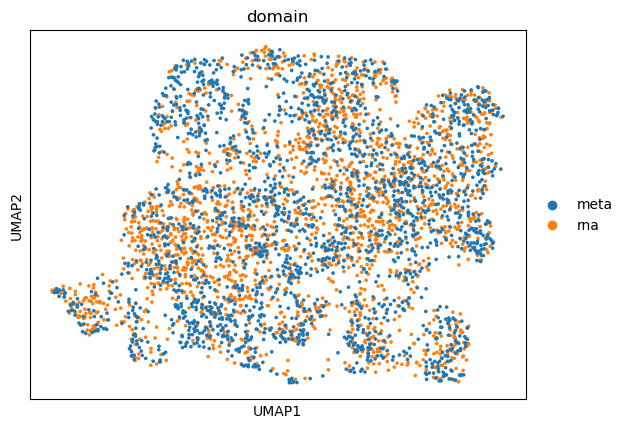

In [14]:
sc.pp.neighbors(combined, use_rep="X_glue", metric="cosine")
sc.tl.umap(combined)
sc.pl.umap(combined, color='domain', wspace=0.65)

/home/by/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/by/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


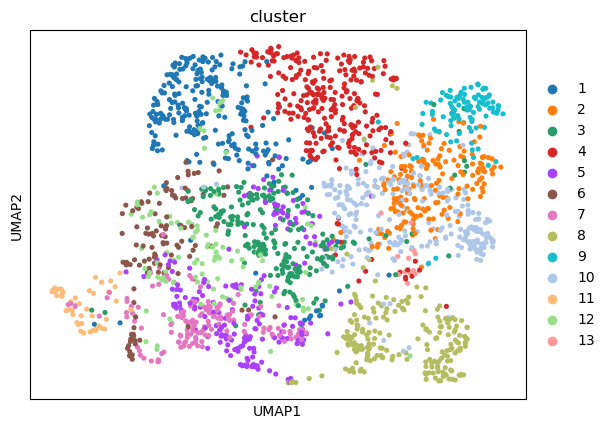

In [17]:
sc.pl.umap(combined[combined.obs['domain'] == 'meta'], color='cluster', wspace=0.65)

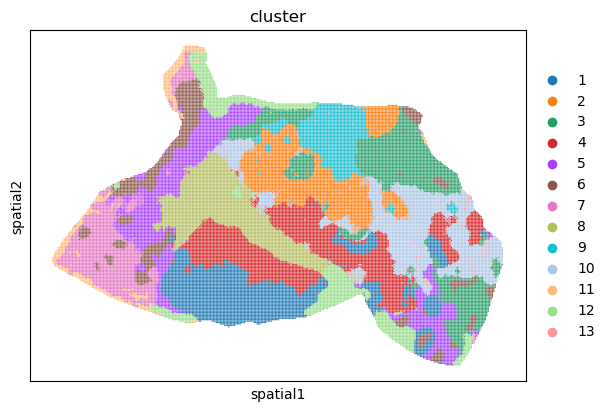

In [18]:
sc.pl.spatial(meta_full, color="cluster", spot_size=1)

/home/by/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/by/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


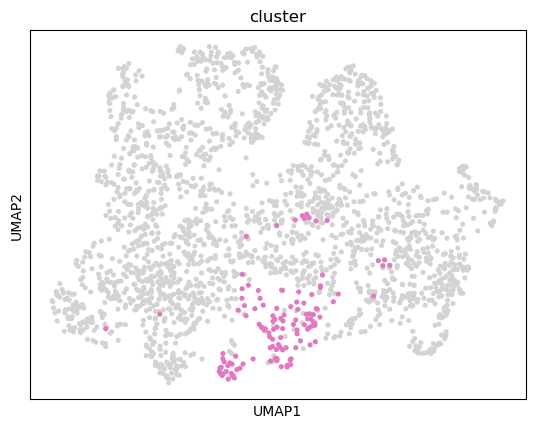

In [16]:
domain_subset = combined[combined.obs['domain'] == 'meta']

# 使用hue参数来指定颜色，并突出显示leiden为'5'或'7'的细胞
sc.pl.umap(domain_subset, color='cluster',  wspace=0.65, 
           legend_loc='None', groups=[ '6'], frameon=True)

/home/by/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/by/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


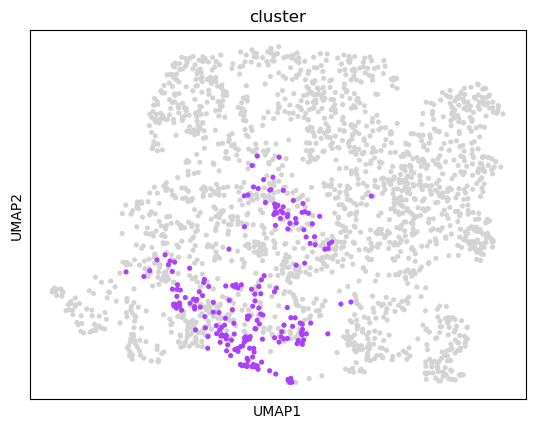

In [25]:
sc.pl.umap(combined[combined.obs['domain'] == 'meta'], color='cluster', wspace=0.65,legend_loc='None',groups=[5])

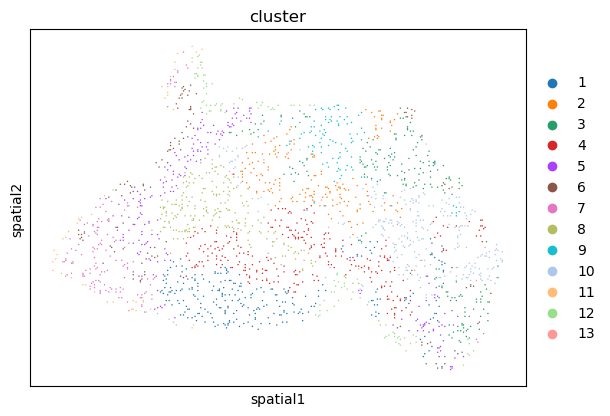

In [19]:
sc.pl.spatial(meta, color="cluster", spot_size=1)

/home/by/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/by/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


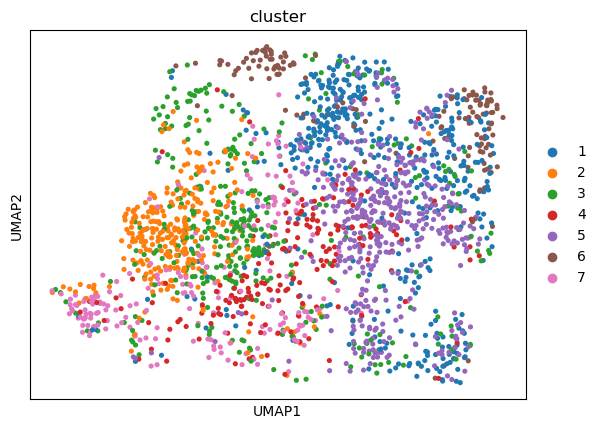

In [21]:
sc.pl.umap(combined[combined.obs['domain'] == 'rna'], color='cluster', wspace=0.65)

/home/by/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/by/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


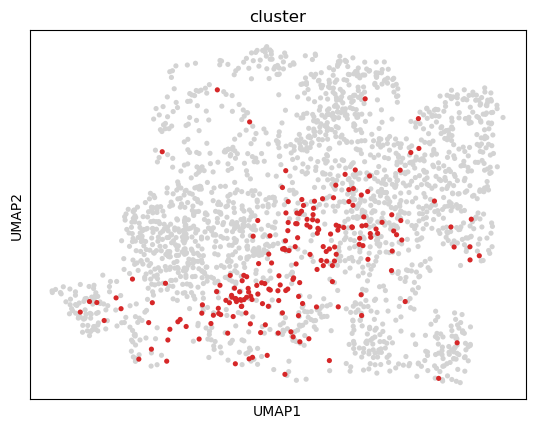

In [23]:
sc.pl.umap(combined[combined.obs['domain'] == 'rna'], color='cluster', wspace=0.65,legend_loc='None',groups=[4])


/home/by/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/by/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


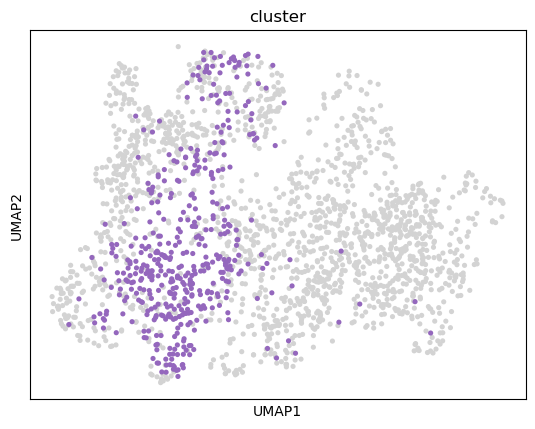

In [20]:
sc.pl.umap(combined[combined.obs['domain'] == 'rna'], color='cluster', wspace=0.65,legend_loc='None',groups=[5])

/home/by/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/by/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


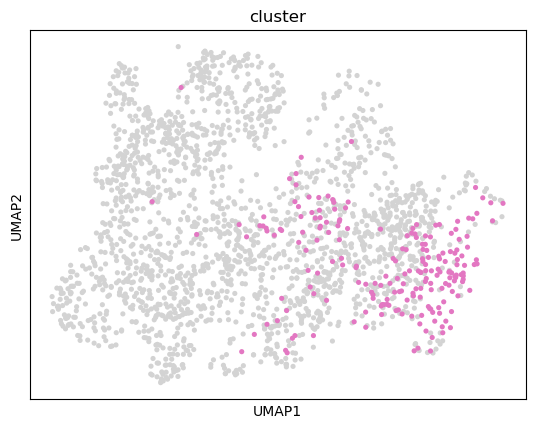

In [22]:
sc.pl.umap(combined[combined.obs['domain'] == 'rna'], color='cluster', wspace=0.65,legend_loc='None',groups=[7])

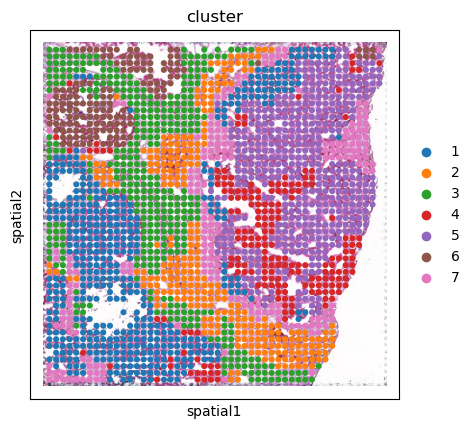

In [22]:
sc.pl.spatial(rna, img_key="hires", color="cluster", size=0.9)

In [26]:
glue.save("glue0719_lbc_clz92_01.dill")
#glue = scglue.models.load_model("glue0621.dill")

In [2]:
glue = scglue.models.load_model("glue0719_lbc_clz92_01.dill")

[INFO] autodevice: Using CPU as computation device.


In [15]:
combined_rna = combined[combined.obs['domain'] == 'rna']

In [16]:
rna_new = rna
rna_new.obsm = combined_rna.obsm

In [17]:
rna_new.write_h5ad("rna0720_lbc_st_scglue.h5ad")

/home/by/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


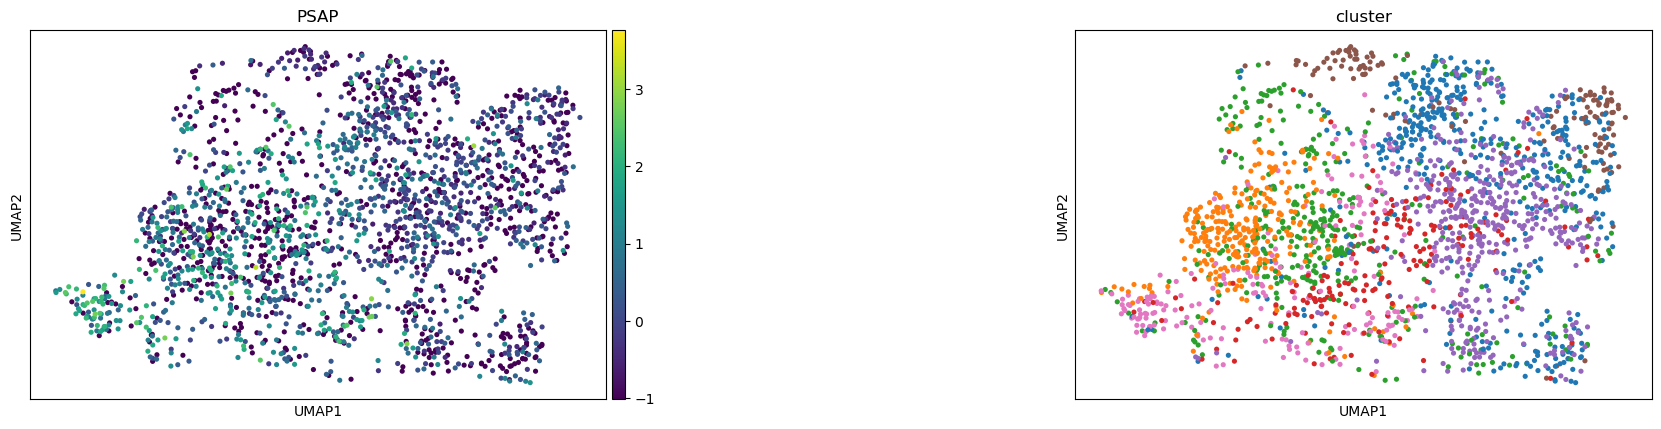

In [18]:
sc.pl.umap(rna_new, color=('PSAP','cluster'), wspace=0.65,legend_loc='None')

In [19]:
combined_meta = combined[combined.obs['domain'] == 'meta']
meta_new = meta
meta_new.obsm = combined_meta.obsm
meta_new.write_h5ad("meta0720_clz_mt_scglue.h5ad")